# MNIST Image Reconstruction
Here, we will try to reconstruct images from the MNIST Database using different encoder-decoder setups

In [1]:
# For automatic file reloading 
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
from datasets.mnist_wrapper import MNISTWrapper

root_path = os.path.dirname(os.path.abspath(os.getcwd()))
mnist_root = os.path.join(root_path, "datasets", "mnist")
print('Dataset Root:\t',mnist_root)
train_dataset = MNISTWrapper(mnist_root,train=True, download=True)
test_dataset = MNISTWrapper(mnist_root, train=False, download=True)
train_dataset_length = int(0.8*len(train_dataset))
val_dataset_length = len(train_dataset) - train_dataset_length
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_dataset_length, val_dataset_length], generator=torch.Generator().manual_seed(42))
print('Train Dataset:\t{}\nVal Dataset:\t{}\nTest Dataset:\t{}\n'.format(len(train_dataset),len(val_dataset),len(test_dataset)))

Dataset Root:	 /Users/ajaynarayanan/Projects/datasets/mnist
Train Dataset:	48000
Val Dataset:	12000
Test Dataset:	10000



The shape of our greyscale images:  torch.Size([28, 28])
Input feature count:  784


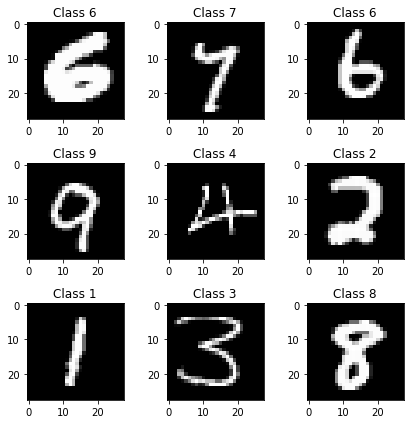

In [25]:
import torchvision
plt.rcParams['figure.figsize'] = (6,6) # Make the figures a bit bigger

for i in range(9):
    image = (train_dataset[i][0].squeeze())
    label = train_dataset[i][1] 
    plt.subplot(3,3,i+1)
    plt.imshow(image, cmap='gray', interpolation='none')
    plt.title("Class {}".format(label.nonzero().item()))
    

# plt.imshow(train_dataset[0][0].squeeze(), cmap='gray',interpolation='none')
    
plt.tight_layout()
print('The shape of our greyscale images: ', image.shape)

input_features = image.shape[0] * image.shape[1]
print('Input feature count: ', input_features)

In [4]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs --port 6006

In [5]:
from torch.utils.tensorboard import SummaryWriter
from pytorch_lightning.loggers import TensorBoardLogger

recon_logger = TensorBoardLogger(save_dir='lightning_logs', name="conv_reconstructor")

### Training the model

In [21]:
from models.image_reconstructor import ConvolutionalReconstructor
from torchinfo import summary
import pytorch_lightning as pl

hparams = {
    'input_channels': 1,
    'lr': 1e-4,
    'activation_function': 'LeakyReLU',
    'batch_size': 2
}

model = ConvolutionalReconstructor(hparams, train_dataset, val_dataset, test_dataset)
# summary(model)

# recon_logger = TensorBoardLogger(save_dir='lightning_logs', name="conv_reconstructor")

trainer = pl.Trainer(
    logger=recon_logger,
    max_epochs=20,
    log_every_n_steps=1,
    progress_bar_refresh_rate=10,
    gpus=1 if torch.cuda.is_available() else None
)

trainer.fit(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/ajaynarayanan/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:608: UserWarning: Checkpoint directory lightning_logs/conv_reconstructor/version_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 10.7 K
1 | decoder | Sequential | 47.6 K
---------------------------------------
58.3 K    Trainable params
0         Non-trainable params
58.3 K    Total params
0.233     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [26]:
trainer.test(model)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                    0.0
        test_loss          0.005298362113535404
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.005298362113535404, 'test_acc': 0.0}]

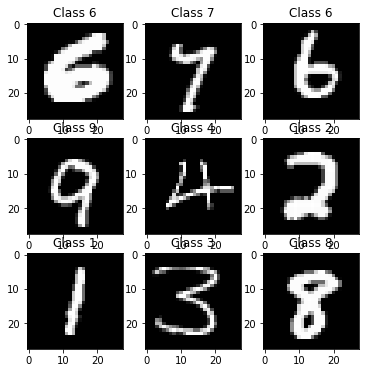

In [27]:
plt.rcParams['figure.figsize'] = (6,6) # Make the figures a bit bigger

for i in range(9):
    image = (train_dataset[i][0].squeeze())
    label = train_dataset[i][1] 
    plt.subplot(3,3,i+1)
    plt.imshow(image, cmap='gray', interpolation='none')
    plt.title("Class {}".format(label.nonzero().item()))

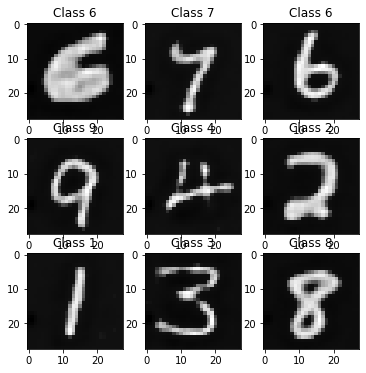

In [28]:
plt.rcParams['figure.figsize'] = (6,6) # Make the figures a bit bigger

model.eval()

for i in range(9):
    image = (train_dataset[i][0].squeeze())
    image = model.regenerate_image(image)
    image = image.detach().numpy().squeeze()
    label = train_dataset[i][1] 
    plt.subplot(3,3,i+1)
    plt.imshow(image, cmap='gray', interpolation='none')
    plt.title("Class {}".format(label.nonzero().item()))